<a href="https://colab.research.google.com/github/Charlotte-99/Classifying_Cosmological_Data/blob/main/CNN_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using CNNs to classify the MNIST Fashion dataset**

Setting up and installing required modules

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.python.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, AveragePooling2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
print(tf.__version__)

2.4.1


Loading the fashion MNIST data set to work with

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Using code as in regularisation code to plot and rescale the downloaded data set

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

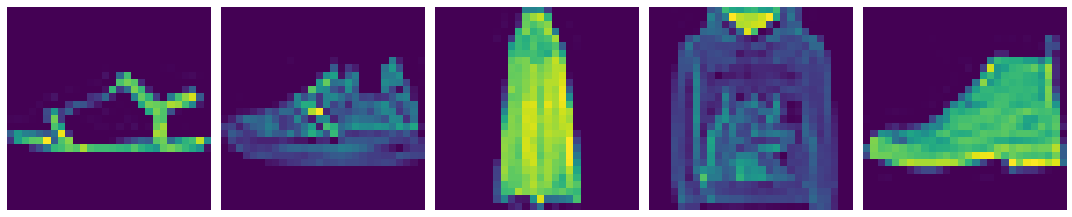

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
sample_images, sample_labels = next(data_gen)
plotImages(sample_images[:5])

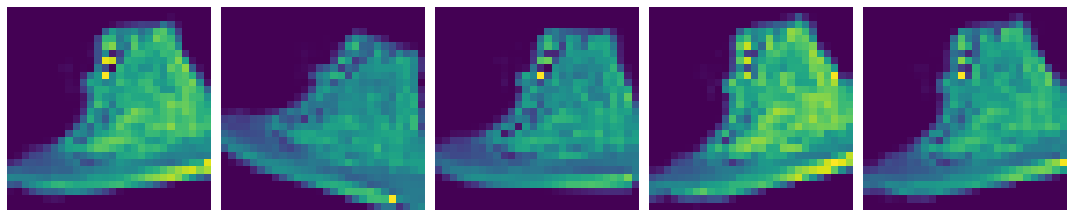

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
augmented_images = [data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Non-CNN Model**

Model built using the TensorFlow tutorial (https://www.tensorflow.org/tutorials/keras/classification) to create a neural network consisting of two fully connected layers, using the Adam optimizer and the sparse categorical cross entropy loss function

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=15)

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5364 - accuracy: 0.8026
Epoch 2/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5340 - accuracy: 0.8043
Epoch 3/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5285 - accuracy: 0.8059
Epoch 4/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5284 - accuracy: 0.8048
Epoch 5/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5290 - accuracy: 0.8054
Epoch 6/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5288 - accuracy: 0.8079
Epoch 7/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5173 - accuracy: 0.8082
Epoch 8/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5223 - accuracy: 0.8086
Epoch 9/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5198 - accuracy: 0.8090
Epoch 10/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.528

This model doesn't give a particularly good accuracy on the test data set, so we are looking to improve on this through exploring different architectures and models

**Basic CNN Model**

As in regularisation model, basic CNN defined with 32 convolutional filters using a 3x3 kernel, then a dense fully connected layer of 128 units and output layer of 10 units with softmax activation

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

Main training routine, as in the regularisation model this uses the Gradient Tape API and has the option to use early stopping

In [ ]:
def trainer(cls, train_image_generator, test_image_generator, 
            verbose=False, batch_size=32, max_epochs=5, early_stopping=False,
            patience=10):
  
  model = cls()

  train_data_gen = train_image_generator.flow(x_train, y_train, 
                                              batch_size=batch_size) 

  test_data_gen = test_image_generator.flow(x_test, y_test, 
                                              batch_size=batch_size) 

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')
  
  #Variables stored for use in plotting results
  global stored_test_loss
  global stored_train_loss
  global epoch_number

  stored_test_loss = []
  stored_train_loss = []
  epoch_number = []

  #Count for early stopping procedure
  final_test_loss = np.inf
  count = 0

  @tf.function
  def train_step(images, labels):
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

  @tf.function
  def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

  for epoch in range(max_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    batches = 0
    for images, labels in train_data_gen:
      train_step(images, labels)
      batches += 1
      if batches >= len(x_train) / batch_size:
        break

    batches = 0
    for images, labels in test_data_gen:
      test_step(images, labels)
      batches += 1
      if batches >= len(x_test) / batch_size:
        break

    epoch_number.append(epoch+1)
    stored_test_loss.append(test_loss.result())
    stored_train_loss.append(train_loss.result())

    if verbose:
      template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
      print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
      
    #Early stopping procedure
    if early_stopping:
      if test_loss.result().numpy() < final_test_loss:
        final_test_loss = test_loss.result().numpy()
        count = 0
      count += 1
      if count > patience:
        break
    else:
      final_test_loss = test_loss.result().numpy()


  return final_test_loss

Run with early stopping implemented

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.37778884172439575, Accuracy: 86.39500427246094, Test Loss: 0.3209723234176636, Test Accuracy: 88.31999969482422
Epoch 2, Loss: 0.24611644446849823, Accuracy: 90.90499877929688, Test Loss: 0.28666719794273376, Test Accuracy: 89.51000213623047
Epoch 3, Loss: 0.1924172043800354, Accuracy: 92.86833190917969, Test Loss: 0.2805270552635193, Test Accuracy: 89.84000396728516
Epoch 4, Loss: 0.14961351454257965, Accuracy: 94.46333312988281, Test Loss: 0.28149789571762085, Test Accuracy: 90.37000274658203
Epoch 5, Loss: 0.11272815614938736, Accuracy: 95.80332946777344, Test Loss: 0.2979324758052826, Test Accuracy: 91.22000122070312
Epoch 6, Loss: 0.08581972122192383, Accuracy: 96.83833312988281, Test Loss: 0.3141686022281647, Test Accuracy: 90.70999908447266
Epoch 7, Loss: 0.06516513973474503, Accuracy: 97.67333221435547, Test Loss: 0.36438918113708496, Test Accuracy: 90.61000061035156
Epoch 8, Loss: 0.04842337220907211, Accuracy: 98.24832916259766, Test Loss: 0.3824649453163147,

This basic CNN model doesn't end up with a model that fits the data well - in this run it only completed 13 epochs because the model started to overfit the training set very rapidly. The final test loss was 0.28052706, leaving room for improvement with further models

Changing Kernel size to 5x5:

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 5, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.3773135840892792, Accuracy: 86.50666809082031, Test Loss: 0.3368423879146576, Test Accuracy: 87.69000244140625
Epoch 2, Loss: 0.2549518644809723, Accuracy: 90.61166381835938, Test Loss: 0.2921588718891144, Test Accuracy: 89.52999877929688
Epoch 3, Loss: 0.2010733187198639, Accuracy: 92.5, Test Loss: 0.2813721299171448, Test Accuracy: 90.38999938964844
Epoch 4, Loss: 0.1634291112422943, Accuracy: 93.88666534423828, Test Loss: 0.30526378750801086, Test Accuracy: 89.92000579833984
Epoch 5, Loss: 0.1272512823343277, Accuracy: 95.18333435058594, Test Loss: 0.31332769989967346, Test Accuracy: 90.06000518798828
Epoch 6, Loss: 0.10317496955394745, Accuracy: 96.05332946777344, Test Loss: 0.32646870613098145, Test Accuracy: 90.73999786376953
Epoch 7, Loss: 0.08183623850345612, Accuracy: 96.94833374023438, Test Loss: 0.3453558683395386, Test Accuracy: 90.44999694824219
Epoch 8, Loss: 0.06453938037157059, Accuracy: 97.58833312988281, Test Loss: 0.40364667773246765, Test Accuracy: 

This gives no noticeable change from using the 3x3 kernel - it still fits the training data well but adapts poorly to the test data set

Experimenting with a variety of regularisation strategies, including L2 regularisation, data augmentation and dropout layers:

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.drop1 = Dropout(0.25)
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.drop2 = Dropout(0.4)
    self.d2 = Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(1))

  def call(self, x):
    x = self.conv1(x)
    x = self.drop1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.drop2(x)
    return self.d2(x)

train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, batch_size=16, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.4837146997451782, Accuracy: 82.8616714477539, Test Loss: 0.33321326971054077, Test Accuracy: 87.5999984741211
Epoch 2, Loss: 0.3467640280723572, Accuracy: 87.4749984741211, Test Loss: 0.3002777397632599, Test Accuracy: 89.1500015258789
Epoch 3, Loss: 0.3000124394893646, Accuracy: 88.99166870117188, Test Loss: 0.2912687361240387, Test Accuracy: 89.52000427246094
Epoch 4, Loss: 0.2694612443447113, Accuracy: 90.0433349609375, Test Loss: 0.2763531506061554, Test Accuracy: 90.08000183105469
Epoch 5, Loss: 0.2438642680644989, Accuracy: 90.81999969482422, Test Loss: 0.288873553276062, Test Accuracy: 89.86000061035156
Epoch 6, Loss: 0.22453071177005768, Accuracy: 91.5250015258789, Test Loss: 0.2860426604747772, Test Accuracy: 90.26000213623047
Epoch 7, Loss: 0.2092241644859314, Accuracy: 92.04999542236328, Test Loss: 0.2966903746128082, Test Accuracy: 90.41999816894531
Epoch 8, Loss: 0.19647535681724548, Accuracy: 92.56666564941406, Test Loss: 0.31439581513404846, Test Accurac

These changes to the CNN did not reduce the final test loss, but they did reduce the amount by which the model was overfitting to the training data, as shown by the test loss remaining lower for later epochs in comparison to models without regularisation techniques applied

**Plotting results**

Run this code after data has been collected to plot results of test and training loss vs epoch

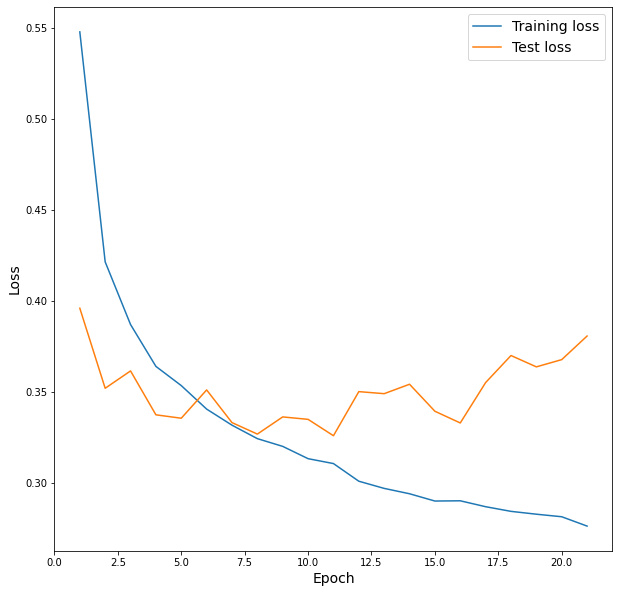

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(epoch_number, stored_train_loss,epoch_number,stored_test_loss)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(('Training loss','Test loss'), fontsize=14)

**Experimenting with different layers of the CNN model**

Experimenting with different numbers of convolutional layers, filters and pooling layers to explore how this will impact the final test loss and the shape of the training and test loss functions. Here the method of creating and training the model has been changed from the previous section, which had been based on the regularisation model used previously.

In [ ]:
def build_model():
  model = Sequential()
  model.add(Conv2D(32, 3, activation='relu', input_shape=(28,28,1)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation = 'softmax'))
  model.summary()

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
model = build_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=1, 
                    validation_data=(x_test, y_test), callbacks=[callback])

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_9 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               2769024   
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 2,787,146
Trainable params: 2,787,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6972 - accuracy: 0.7575 - val_loss

**LeNet Model**

The LeNet model was designed to use 3 convolutional layers, 2 pooling layers, and 2 fully connected layers

In [ ]:
x_train_padding = np.pad(x_train,((0,0), (2,2), (2,2), (0,0)))
x_test_padding = np.pad(x_test,((0,0), (2,2), (2,2), (0,0)))

def build_model():
  model = Sequential()
  model.add(Conv2D(6, 5, activation='relu', input_shape=(32,32,1)))
  model.add(MaxPooling2D())
  model.add(Conv2D(16, 5, activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(120, 5, activation='relu'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation = 'softmax'))
  model.summary()

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

Running this model:

In [ ]:
model = build_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)
history = model.fit(x_train_padding, y_train, batch_size=256, epochs=50, verbose=1, 
                    validation_data=(x_test_padding, y_test), callbacks=[callback])

test_loss, test_acc = model.evaluate(x_test_padding,  y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                1

This model has not improved on the final test loss determined by the basic CNN model - but it does have the advantage of having far fewer trainable parameters to modify train which allows the model to be trained in a shorter time period. However, with current computing power, a model on this scale is very quick to run anyway so the advantage that this gives is marginal.

**AlexNet**

AlexNet is known as the first deep CNN, a network based on this structure has been created and implemented on the data set here:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

x_train_upsampled = tf.image.resize(x_train, [112,112])/255
x_test_upsampled = tf.image.resize(x_test, [112,112])/255


def build_model():
  model = Sequential()
  model.add(Conv2D(96, 11, activation='relu', input_shape=(112,112,1), strides=4))
  model.add(AveragePooling2D(strides=2))
  model.add(Conv2D(256, 5, activation='relu', padding='same'))
  model.add(AveragePooling2D(strides=2))
  model.add(Conv2D(384, 3, activation='relu', padding='same'))
  model.add(Conv2D(384, 3, activation='relu', padding='same'))
  model.add(Conv2D(384, 3, activation='relu', padding='same'))
  model.add(AveragePooling2D(strides=2))
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(10, activation = 'softmax'))

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
model = build_model()

print(model.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)
history = model.fit(x_train_upsampled, y_train, batch_size=256, epochs=50, verbose=1, 
                    validation_data=(x_test_upsampled, y_test), callbacks=[callback])

test_loss, test_acc = model.evaluate(x_test_upsampled,  y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        11712     
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       614656    
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 384)         1

Using the AlexNet architecture led to a slight improvement in the test accuracy and loss, but this is only a marginal increase so may be a random fluctuation in the results. More repeats would be required to identify if this is the case.

**Plotting Results**

Code to run after the modified CNN, LeNet or AlexNet models to plot training and test loss as a function of epoch

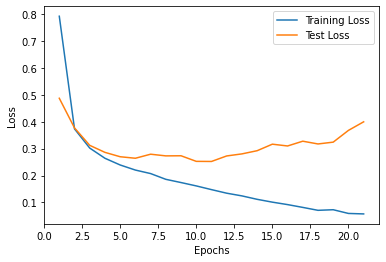

In [ ]:
loss_values = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()